Cell Voltage: 1.993 V
H2O2 Concentration: 1.151e+04 mol/m^3
HO Concentration: 8.678e-12 mol/m^3
Fluoride Release Rate: 6.846e-08 g/cm^2/h
New Membrane Thickness: 1.776e-02 cm
Degraded Activation Overvoltage: 0.686 V
Degraded Ohmic Overvoltage: 0.136 V


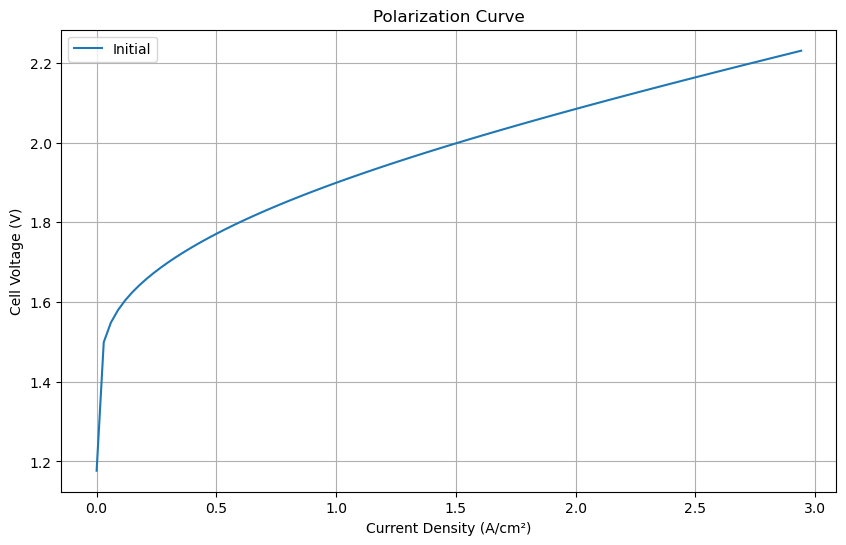

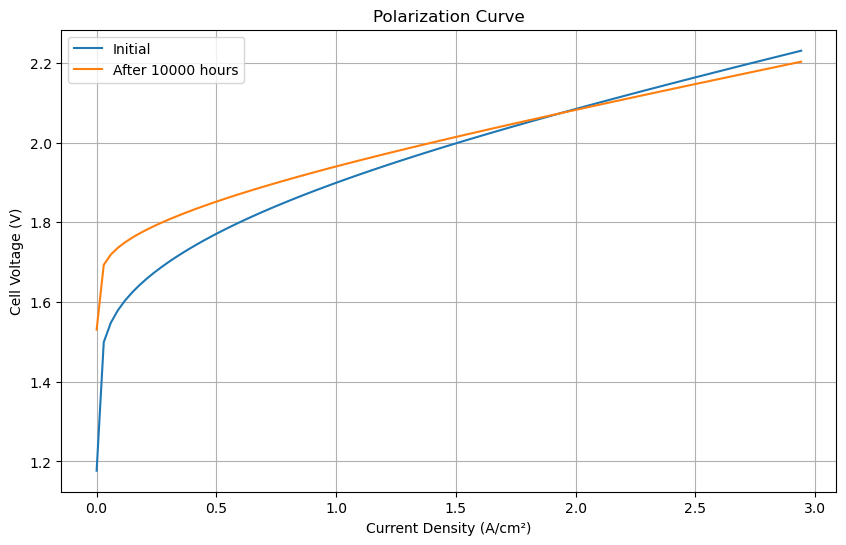

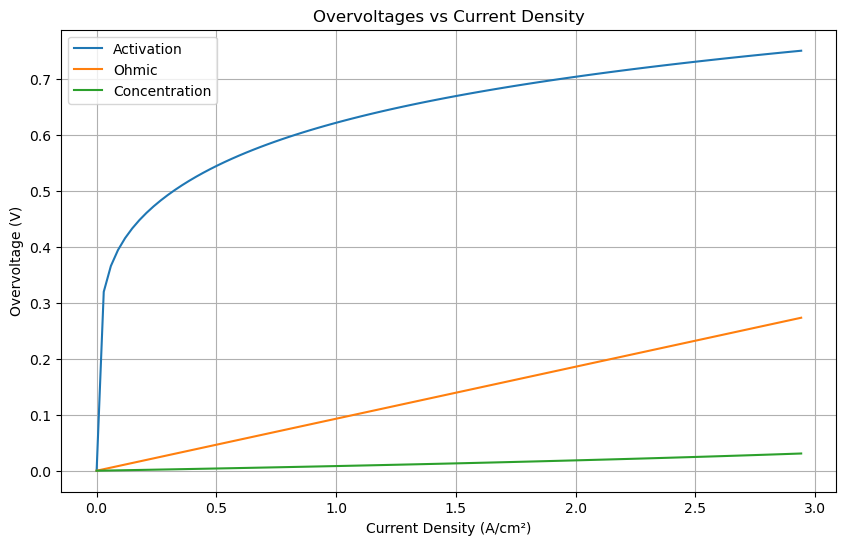

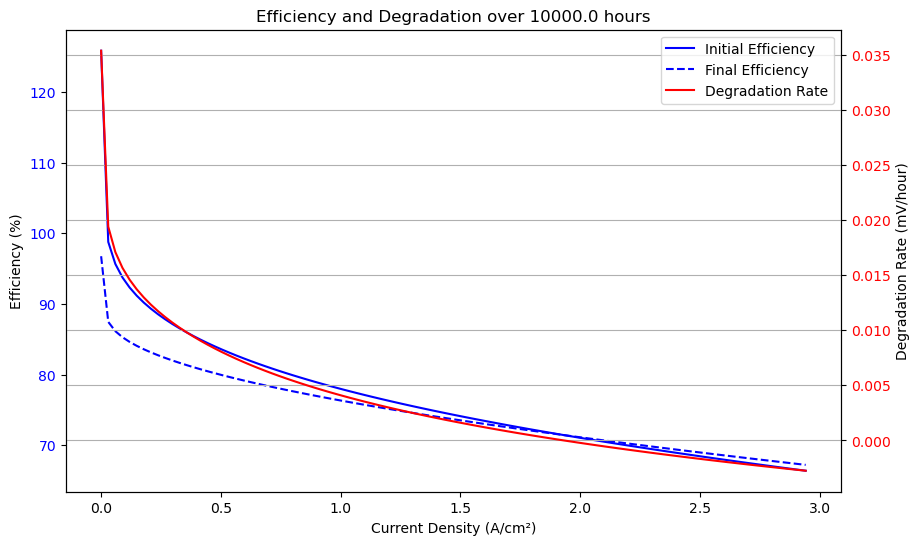

In [9]:
import math
import numpy as np

import matplotlib.pyplot as plt


class ELCellStack:
    def __init__(self):
        # Input parameters
        self.R = 8.314  # Ideal gas constant [J/mol/K]
        self.F = 96485  # Faraday's constant [C]
        self.A = 680  # Area of cell [cm^2]
        self.N_cells = 102  # Number of cells
        self.Alpha = 0.5  # Transfer coefficient
        self.il = 6  # Limiting current density [A/cm^2]
        self.lm = 1.78e-2  # Membrane thickness [cm]
        self.lambdam = 20  # Membrane hydration parameter
        self.roughness_an = 7.23e2  # roughness factor [cm^2/cm^2]
        self.roughness_cat = 2.33e2  # roughness factor[cm^2/cm^2]
        self.i0ref_an = 2.3e-7  # anode exchange current density at the reference temperature [A/cm^2]
        self.i0ref_cat = 1e-3  # cathode exchange current density at the reference temperature [A/cm^2]
        self.vthn = 1.481  # thermobeutral voltage [V]
        self.MmH2O = 18  # water molar mass [g/mol]
        self.rhoH2O = 997  # water density [kg/m^3]
        self.Ea_an = 76000  # anode activation energy [J/mol]
        self.Ea_cat = 4300  # cathode activation energy [J/mol]
        self.Tref = 298  # reference temperature [K]

def PsatH2O(Tk):
    Tc = Tk - 273.15
    return 610e-5 * math.exp((Tc / (Tc + 238.3)) * 17.2694)  # [bar]

def ENernst(Tk, pres):
    a = ELCellStack()
    pcat = pres  # pressure at the cathode [bar]
    pan = pres  # pressure at the anode [bar]
    ppH2 = pan - PsatH2O(Tk)  # partial pressure Hydrogen [bar]
    ppO2 = pcat - PsatH2O(Tk)  # partial pressure Oxygen [bar]
    E = 1.229 - 0.9e-3 * (Tk - 298)  # standard potential [V]
    Gf_liq = E * 2 * a.F  # Gibbs free energy [J/mol]
    return Gf_liq / (2 * a.F) - ((a.R * Tk) * math.log(PsatH2O(Tk) / (ppH2 * (ppO2 ** 0.5)))) / (2 * a.F)  # [V]

def VAct(Tk, I):
    a = ELCellStack()
    # exchange current density
    i0_an = a.roughness_an * a.i0ref_an * math.exp(-(a.Ea_an / a.R) * (1 / Tk - 1 / 353))  # [A/cm^2]
    i0_cat = a.roughness_cat * a.i0ref_cat * math.exp(-(a.Ea_cat / a.R) * (1 / Tk - 1 / 353))  # [A/cm^2]
    c = a.R * Tk / (a.Alpha * a.F)
    b1 = math.asinh((I / a.A) / (2 * i0_an))
    b2 = math.asinh((I / a.A) / (2 * i0_cat))
    return c * (b1 + b2)  # [V]

def VOhm(Tk, I):
    a = ELCellStack()
    # Area Specific ohmic Resistance
    r = a.lm / ((0.005139 * a.lambdam + 0.00326) * math.exp(1267 * (1 / 303 - 1 / Tk)))  # [Ohm*cm^2]
    return (I / a.A) * r  # [V]

def VConc(Tk, I):
    a = ELCellStack()
    return a.R * Tk / (2 * a.F) * (1 + 1 / a.Alpha) * math.log(a.il / (a.il - (I / a.A)))  # [V]

def conc(Tk, I, pres):
    a = ELCellStack()
    i = I / (a.A * 1e-4)
    eta = 0.695  # Equilibrium overpotential 2e-ORR [V]
    pO2 = pres - PsatH2O(Tk)  # Oxygen partial pressure [bar]
    sO2 = 1.62e-6 * math.exp(603 / Tk) * 1e5  # Oxygen solubility [mol/m^3/bar]
    cO2 = sO2 * pO2  # Oxygen concentration [mol/m^3]
    Qc = a.MmH2O * i * (a.A * 1e-4) / (2 * a.F * a.rhoH2O * 1e3)  # consumed waterflow [m^3/s]
    
    # Add a small constant to prevent taking log of zero or negative values
    Qt = (-0.332 * math.log(max(i, 1e-10)) + 5.59) * Qc  # transferred waterflow [m^3/s]
    
    vH2O = Qt / (a.A * 1e-4)  # water velocity [m/s]
    EW = 1.100  # Nafion equivalent weight [kg/mol]
    rhonaf = 1980  # Nafion dry membrane density [kg/m^3]
    Cmemb = rhonaf / EW  # Membrane concentration [mol/m^3]
    eclc = 1e-5  # thickness cathode catalyst layer [m]
    gammac = 150  # rugosity cathode [m^2/m^2]
    k1o = 7.068e2  # Kinetic constant [m^7/mol^2/s]
    AH2O2 = 42450  # Activation energy [J/mol]
    alfa = 0.5  # Transfers coefficient of the reaction [-]
    cH = (1980 + 32.4 * a.lambdam) / ((1 + 0.0648 * a.lambdam) * EW)
    k1 = k1o * math.exp(-AH2O2 / (a.R * Tk)) * math.exp(-alfa * a.F * eta / (a.R * a.Tref))  # Kinetic constant [m^7/mol^2/s]
    R1 = k1 * cO2 * cH**2  # Kinetic rate [mol/m^2/s]
    v1 = gammac * R1 / eclc  # Formation rate [mol/m^3/s]
    k2 = 1.2e-7  # Kinetic constant [s^(-1)]
    k6 = 2.7e4  # Kinetic constant [m^3/mol/s]
    k7 = 1.2e7  # Kinetic constant [m^3/mol/s]
    k10 = 1e3  # Kinetic constant [m^3/mol/s]
    e = k7 * cO2 + k10 * Cmemb - vH2O / eclc
    A2 = -3 * k2 + vH2O / eclc
    B = e * vH2O / (eclc * k6) - v1 - e * k2 / k6
    C = -e * v1 / k6
    CH2O2 = (-B + math.sqrt(max(B**2 - 4 * A2 * C, 0))) / (2 * A2)  # Hydrogen peroxide concentration [mol/m^3]
    CHO = vH2O / (eclc * k6) - k2 / k6 - v1 / (k6 * CH2O2)  # Hydroxil concentration [mol/m^3]
    return CH2O2, CHO


def FRRlm(CHO, t):
    a = ELCellStack()
    k10 = 1e3  # Kinetic constant [m^3/mol/s]
    EW = 1.100  # Nafion equivalent weight [kg/mol]
    rhonaf = 1980  # Nafion dry membrane density [kg/m^3]
    Cmemb = rhonaf / EW  # Membrane concentration [mol/m^3]
    v10 = k10 * CHO * Cmemb  # Chemical reaction rate [mol/m^3/s]
    vF = 3.6 * v10  # F- Formation rate [mol/m^3/s]
    MMF = 18.998403  # Molar mass of the fluoride ions [g/mol]
    FRR = vF * MMF * (a.lm * 1e-2) * 3600 / 1e4  # Fluoride Release Rate [g/cm^2/h]
    TR = FRR / (0.82 * 2)  # thickness reduction rate [cm/h]
    if TR > 0:
        lm = a.lm - TR * t  # membrane thickness [cm]
    else:
        lm = a.lm
    return FRR, lm

def VAct_deg(Tk, I, pres, lm):
    a = ELCellStack()
    EW = 1.100  # Nafion equivalent weight [kg/mol]
    w = a.lambdam * a.MmH2O * 1e-3 / EW  # Normalized water uptake
    SH2 = 1 / (w * 1.09e5 * math.exp(77 / Tk)) * 1e5  # Hydrogen solubility in water [mol/m^3/bar]
    DH2 = 1.23e-6 * math.exp(-(-2602) / Tk)  # Hydrogen diffusivity in water [m^2/s]
    ppH2 = pres - PsatH2O(Tk)  # Hydrogen partial pressure [bar]
    iH2 = SH2 * DH2 * ppH2 / lm * 2 * a.F  # gas crossover current [A/cm^2]
    i0_an = a.roughness_an * a.i0ref_an * math.exp(-(a.Ea_an / a.R) * (1 / Tk - 1 / 353))
    i0_cat = a.roughness_cat * a.i0ref_cat * math.exp(-(a.Ea_cat / a.R) * (1 / Tk - 1 / 353))
    c = a.R * Tk / (2 * a.Alpha * a.F)
    nx = a.R * Tk * math.log(iH2 / i0_cat) / a.F  # gas crossover overvoltage [V]
    b1 = math.asinh((I / a.A) / (2 * i0_an))
    b2 = math.asinh((I / a.A) / (2 * i0_cat))
    return c * (b1 + b2) + nx  # [V]

def VOhm_deg(Tk, I, pres, lm):
    a = ELCellStack()
    # Area Specific ohmic Resistance
    r = lm / ((0.005139 * a.lambdam + 0.00326) * math.exp(1268 * (1 / 303 - 1 / Tk)))  # [Ohm*cm^2]
    return (I / a.A) * r  # [V]


# Create an instance of ELCellStack
cell_stack = ELCellStack()

# Set some example parameters
Tk = 353  # Temperature in Kelvin (80°C)
I = 1000  # Current in Amperes
pres = 1  # Pressure in bar

# Calculate various voltages
e_nernst = ENernst(Tk, pres)
v_act = VAct(Tk, I)
v_ohm = VOhm(Tk, I)
v_conc = VConc(Tk, I)

# Calculate total cell voltage
v_cell = e_nernst + v_act + v_ohm + v_conc

print(f"Cell Voltage: {v_cell:.3f} V")

# Calculate pollutant concentrations
ch2o2, cho = conc(Tk, I, pres)

print(f"H2O2 Concentration: {ch2o2:.3e} mol/m^3")
print(f"HO Concentration: {cho:.3e} mol/m^3")

# Calculate Fluoride Release Rate and membrane thickness after 1000 hours
t = 1000  # time in hours
frr, lm_new = FRRlm(cho, t)

print(f"Fluoride Release Rate: {frr:.3e} g/cm^2/h")
print(f"New Membrane Thickness: {lm_new:.3e} cm")

# Calculate degraded voltages
v_act_deg = VAct_deg(Tk, I, pres, lm_new)
v_ohm_deg = VOhm_deg(Tk, I, pres, lm_new)

print(f"Degraded Activation Overvoltage: {v_act_deg:.3f} V")
print(f"Degraded Ohmic Overvoltage: {v_ohm_deg:.3f} V")



import math

def plot_polarization_curve(cell_stack, Tk, pres, I_range, time=0):
    voltages = []
    voltages_deg = []
    for I in I_range:
        e_nernst = ENernst(Tk, pres)
        v_act = VAct(Tk, I)
        v_ohm = VOhm(Tk, I)
        v_conc = VConc(Tk, I)
        v_cell = e_nernst + v_act + v_ohm + v_conc
        voltages.append(v_cell)
        
        # Calculate degraded voltage
        if time > 0:
            ch2o2, cho = conc(Tk, I, pres)
            _, lm_new = FRRlm(cho, time)
            v_act_deg = VAct_deg(Tk, I, pres, lm_new)
            v_ohm_deg = VOhm_deg(Tk, I, pres, lm_new)
            v_cell_deg = e_nernst + v_act_deg + v_ohm_deg + v_conc
            voltages_deg.append(v_cell_deg)
    
    plt.figure(figsize=(10, 6))
    plt.plot(I_range / cell_stack.A, voltages, label='Initial')
    if time > 0:
        plt.plot(I_range / cell_stack.A, voltages_deg, label=f'After {time} hours')
    plt.xlabel('Current Density (A/cm²)')
    plt.ylabel('Cell Voltage (V)')
    plt.title('Polarization Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_overvoltages(cell_stack, Tk, pres, I_range):
    v_act_list = []
    v_ohm_list = []
    v_conc_list = []
    
    for I in I_range:
        v_act_list.append(VAct(Tk, I))
        v_ohm_list.append(VOhm(Tk, I))
        v_conc_list.append(VConc(Tk, I))
    
    plt.figure(figsize=(10, 6))
    plt.plot(I_range / cell_stack.A, v_act_list, label='Activation')
    plt.plot(I_range / cell_stack.A, v_ohm_list, label='Ohmic')
    plt.plot(I_range / cell_stack.A, v_conc_list, label='Concentration')
    plt.xlabel('Current Density (A/cm²)')
    plt.ylabel('Overvoltage (V)')
    plt.title('Overvoltages vs Current Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_efficiency_and_degradation(cell_stack, Tk, pres, I_range, time_range):
    efficiency_initial = []
    efficiency_final = []
    degradation_rate = []

    for I in I_range:
        # Initial efficiency
        v_cell_initial = ENernst(Tk, pres) + VAct(Tk, I) + VOhm(Tk, I) + VConc(Tk, I)
        efficiency_initial.append(cell_stack.vthn / v_cell_initial * 100)
        
        # Final efficiency (after max time)
        ch2o2, cho = conc(Tk, I, pres)
        _, lm_new = FRRlm(cho, time_range[-1])
        v_act_deg = VAct_deg(Tk, I, pres, lm_new)
        v_ohm_deg = VOhm_deg(Tk, I, pres, lm_new)
        v_cell_final = ENernst(Tk, pres) + v_act_deg + v_ohm_deg + VConc(Tk, I)
        efficiency_final.append(cell_stack.vthn / v_cell_final * 100)
        
        # Degradation rate
        degradation_rate.append((v_cell_final - v_cell_initial) / time_range[-1] * 1000)  # mV/hour

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    ax1.plot(I_range / cell_stack.A, efficiency_initial, 'b-', label='Initial Efficiency')
    ax1.plot(I_range / cell_stack.A, efficiency_final, 'b--', label='Final Efficiency')
    ax1.set_xlabel('Current Density (A/cm²)')
    ax1.set_ylabel('Efficiency (%)')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2.plot(I_range / cell_stack.A, degradation_rate, 'r-', label='Degradation Rate')
    ax2.set_ylabel('Degradation Rate (mV/hour)')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title(f'Efficiency and Degradation over {time_range[-1]} hours')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.grid(True)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Create an instance of ELCellStack
    cell_stack = ELCellStack()

    # Set some example parameters
    Tk = 353  # Temperature in Kelvin (80°C)
    I = 1000  # Current in Amperes
    pres = 1  # Pressure in bar

    # Generate plots
    I_range = np.linspace(1, 2000, 100)
    plot_polarization_curve(cell_stack, Tk, pres, I_range)
    plot_polarization_curve(cell_stack, Tk, pres, I_range, time=10000)  # After 10000 hours
    plot_overvoltages(cell_stack, Tk, pres, I_range)

    time_range = np.linspace(1, 10000, 100)
    plot_efficiency_and_degradation(cell_stack, Tk, pres, I_range, time_range)